# Intercomparison

**Author:**

**Last updated:**

**Description:** Runs intercomparison for [Country Year]

## 1. Setup

In [ ]:
# !earthengine authenticate

In [1]:
!git clone https://github.com/nasaharvest/crop-mask.git

Cloning into 'crop-mask'...
remote: Enumerating objects: 12074, done.
remote: Counting objects: 100% (1485/1485), done.
remote: Compressing objects: 100% (449/449), done.
remote: Total 12074 (delta 1102), reused 1232 (delta 1009), pack-reused 10589
Receiving objects: 100% (12074/12074), 125.43 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (7824/7824), done.
Updating files: 100% (208/208), done.


In [2]:
%cd crop-mask/

/content/crop-mask


In [3]:
!git checkout area-estimate-from-multi-land-cover

Branch 'area-estimate-from-multi-land-cover' set up to track remote branch 'area-estimate-from-multi-land-cover' from 'origin'.
Switched to a new branch 'area-estimate-from-multi-land-cover'


In [ ]:
!pip install cartopy -qq
!pip install rasterio -qq
!pip install dvc[gs] -qq

In [71]:
import ee
import geemap
import sys
import pandas as pd
import numpy as np

import geopandas as gpd
from pathlib import Path

ee.Authenticate()
ee.Initialize(project="bsos-geog-harvest1")

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL, get_ensemble_area
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [48]:
country = "Senegal"

if country not in TEST_CODE:
    print(f"WARNING: {country} not found in TEST_CODE in src/compare_covermaps.py")
if country not in TEST_COUNTRIES:
    print(f"WARNING: {country} not found in TEST_COUNTRIES in src/compare_covermaps.py")
if country not in TEST_CODE or country not in TEST_COUNTRIES:
    print("Please update src/compare_covermaps.py and restart the notebook.")
else:
    country_code = TEST_CODE[country]
    # dataset_path = "../" + TEST_COUNTRIES[country]

In [35]:
# dataset_path = TEST_COUNTRIES[country]
dataset_path = 'data/datasets/Senegal_CEO_2022.csv'

In [7]:
# ceo_set1 = './data/ref_sample/ceo-Kenya-Crop-Area-Estimation-Reference-Sample-2019---Set-1-sample-data-2024-03-14.csv'
# ceo_set2 = './data/ref_sample/ceo-Kenya-Crop-Area-Estimation-Reference-Sample-2019---Set-2-sample-data-2024-03-14.csv'

In [8]:
def reference_sample_agree(ceo_ref1, ceo_ref2):
    ceo_ref1 = pd.read_csv(ceo_ref1)
    ceo_ref2 = pd.read_csv(ceo_ref2)

    assert ceo_ref1.columns[-1] == ceo_ref2.columns[-1]

    label_question = ceo_ref1.columns[-1]

    print(f"Number of NANs/ missing answers in set 1: {ceo_ref1[label_question].isna().sum()}")
    print(f"Number of NANs/ missing answers in set 2: {ceo_ref2[label_question].isna().sum()}")

    if ceo_ref1.shape[0] != ceo_ref2.shape[0]:
        print("The number of rows in the reference sets are not equal.")
        print("Checking for duplictes on 'plotid'..")
        print(
            " Number of duplicated in set 1: %s" % ceo_ref1[ceo_ref1.plotid.duplicated()].shape[0]
        )
        print(
            " Number of duplicated in set 2: %s" % ceo_ref2[ceo_ref2.plotid.duplicated()].shape[0]
        )
        print("Removing duplicates and keeping the first...")
        ceo_ref1 = ceo_ref1.drop_duplicates(subset="plotid", keep="first")
        ceo_ref2 = ceo_ref2.drop_duplicates(subset="plotid", keep="first")

        ceo_ref1.set_index("plotid", inplace=True)
        ceo_ref2.set_index("plotid", inplace=True)
    else:
        print("The number of rows in the reference sets are equal.")

    ceo_agree = ceo_ref1[ceo_ref1[label_question] == ceo_ref2[label_question]]

    print(
        "Number of samples that are in agreement: %d out of %d (%.2f%%)"
        % (
            ceo_agree.shape[0],
            ceo_ref1.shape[0],
            ceo_agree.shape[0] / ceo_ref1.shape[0] * 100,
        )
    )
    ceo_agree_geom = gpd.GeoDataFrame(
        ceo_agree,
        geometry=gpd.points_from_xy(ceo_agree.lon, ceo_agree.lat),
        crs="EPSG:4326",
    )

    label_responses = ceo_agree_geom[label_question].unique()
    assert len(label_responses) == 2

    for r, row in ceo_agree_geom.iterrows():

        try:
            if (
                row[label_question].lower() == "crop"
                or row[label_question].lower() == "cropland"
                or row[label_question].lower() == "planted"
            ):
                ceo_agree_geom.loc[r, CLASS_COL] = 1
            elif(
                row[label_question].lower() == "non-crop"
                or row[label_question].lower() == "non-cropland"
                or row[label_question].lower() == "not planted"
            ):
                ceo_agree_geom.loc[r, CLASS_COL] = 0
        except IndexError:
            ceo_agree_geom.loc[r, CLASS_COL] = 255

    ceo_agree_geom = ceo_agree_geom[ceo_agree_geom[CLASS_COL] != 255]

    ceo_agree_geom[CLASS_COL] = ceo_agree_geom[CLASS_COL].astype(int)
    ceo_agree_geom[COUNTRY_COL] = country
    ceo_agree_geom = ceo_agree_geom[['lat','lon',CLASS_COL, COUNTRY_COL, 'geometry']]

    return ceo_agree_geom

In [9]:
gdf = reference_sample_agree(ceo_set1,ceo_set2)
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

Number of NANs/ missing answers in set 1: 2
Number of NANs/ missing answers in set 2: 0
The number of rows in the reference sets are equal.
Number of samples that are in agreement: 487 out of 544 (89.52%)


In [ ]:
!dvc pull data/datasets

In [76]:
if not Path(dataset_path).exists():
    print(f"WARNING: Dataset: {dataset_path} not found, run `dvc pull data/datasets from root.")
else:
    df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
    df = df[(df["class_probability"] != 0.5)].copy()
    # use only test data because validation points used for harvest-dev map
    df = df[df["subset"] == "testing"].copy()
    df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
    df[COUNTRY_COL] = country

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
    gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

## 3. Run intercomparison

In [50]:
gdf.head()

,lat,lon,class_probability,subset,binary,country,geometry
0,15.033306,-16.937735,0.000000,testing,0,Senegal,POINT (-16.93773 15.03331)
4,14.799744,-15.329750,0.000000,testing,0,Senegal,POINT (-15.32975 14.79974)
5,14.260755,-14.656014,0.333333,testing,0,Senegal,POINT (-14.65601 14.26076)
6,16.255015,-15.212969,0.000000,testing,0,Senegal,POINT (-15.21297 16.25502)
10,16.201116,-16.003487,0.000000,testing,0,Senegal,POINT (-16.00349 16.20112)


In [ ]:
gdf2.head()

,lat,lon,class_probability,subset,binary,country,geometry
4,0.725122,34.386282,0.0,testing,0,Kenya,POINT (34.38628 0.72512)
14,0.621939,34.466496,0.0,testing,0,Kenya,POINT (34.46650 0.62194)
46,0.226497,34.054859,0.0,testing,0,Kenya,POINT (34.05486 0.22650)
53,0.096834,33.951959,0.0,testing,0,Kenya,POINT (33.95196 0.09683)
62,0.032072,33.968469,0.0,testing,0,Kenya,POINT (33.96847 0.03207)


In [ ]:
join_gdf = pd.concat([gdf, gdf2])
join_gdf.drop(columns=['class_probability', 'subset'])

,lat,lon,binary,country,geometry
0,2.403553,34.988630,0,Kenya,POINT (34.98863 2.40355)
1,0.237452,40.436913,0,Kenya,POINT (40.43691 0.23745)
2,4.203261,35.525785,0,Kenya,POINT (35.52579 4.20326)
3,1.786133,35.345029,0,Kenya,POINT (35.34503 1.78613)
4,-2.088707,41.092916,1,Kenya,POINT (41.09292 -2.08871)
...,...,...,...,...,...
8594,0.633255,34.313450,1,Kenya,POINT (34.31345 0.63326)
8595,0.630631,34.314150,1,Kenya,POINT (34.31415 0.63063)
8603,0.625610,34.307610,1,Kenya,POINT (34.30761 0.62561)
8632,0.694220,34.369890,1,Kenya,POINT (34.36989 0.69422)


In [72]:
TARGETS = {k:v for k,v in TARGETS.items()}
for k, v in TARGETS.items():
    if country not in v.countries:
        continue
    if v.year is None:
        v.year = v.collection_years[v.countries.index(country)]

In [73]:
reference_year = 2022
TARGETS = {k: v for k, v in TARGETS.items() if v.year in range(reference_year - 2, reference_year + 1)}
# TARGETS = {k: v for k, v in TARGETS.items() if v.year in [reference_year - 2, reference_year, reference_year + 2]}

In [79]:
for a in range(reference_year - 2, reference_year +1):
    print(a)

2020
2021
2022


In [77]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Senegal] sampling worldcover-v100...
[Senegal] sampling worldcover-v200...
[Senegal] sampling worldcereal-v100...


In [13]:
# for cropmap in TARGETS.values():
#     if country not in cropmap.countries:
#         continue
#     print(f"[{country}] sampling " + cropmap.title + "...")
#     map_sampled = cropmap.extract_test(join_gdf).copy()
#     join_gdf = pd.merge(join_gdf, map_sampled, on=["lat", "lon"], how="left")
#     join_gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

In [81]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    a_j[cropmap.title] = cropmap.compute_map_area(country, export=True, dataset_name=cropmap.title).copy() # I already have the export map areas
    # a_j[cropmap.title] = cropmap.compute_map_area(country, dataset_name=cropmap.title).copy()
    # a_j[cropmap.title] = np.array([None,None])


[Senegal] calculating pixel area for worldcover-v100...
Export task started for worldcover-v100, Senegal. Returning null for now.
[Senegal] calculating pixel area for worldcover-v200...
Export task started for worldcover-v200, Senegal. Returning null for now.
[Senegal] calculating pixel area for worldcereal-v100...
Export task started for worldcereal-v100, Senegal. Returning null for now.


In [83]:
# update a_j values with exported values
for cropmap in a_j.keys():
    try:
        area_df = pd.read_csv(f'./Crop_NonCrop_Area_Sum_Export-{country}-{cropmap}.csv')
    except:
        continue
    crop_area = int(area_df['crop_sum'][0])
    noncrop_area = int(area_df['noncrop_sum'][0])
    a_j[cropmap] = np.array([noncrop_area, crop_area])

In [85]:
# Change None to nan
a_j = {k: np.array([np.nan, np.nan]) if np.any(v == None) else v for k,v in a_j.items()}

In [86]:
from src.area_utils import compute_area_estimate, compute_area_error_matrix, compute_std_p_i
from sklearn.metrics import confusion_matrix

In [87]:
def compute_area_estimate(dataset, true, pred, a_j, resolution):
    cm = confusion_matrix(true, pred)
    total_px = a_j.sum()
    w_j = a_j / total_px

    am = compute_area_error_matrix(cm, w_j)
    a_i = am.sum(axis=1)
    std_a_i = compute_std_p_i(w_j, am, cm)
    err_a_i = 1.96 * std_a_i

    a_px = total_px * a_i
    err_px = err_a_i * total_px
    return pd.DataFrame(
        data={
            "dataset": dataset,
            "area_ha": a_px[1] * (resolution**2) / (100**2),
            "err_ha": err_px[1] * (resolution**2) / (100**2),
        },
        index=[0],
    ).round(2)

In [111]:
comparisons = []
area_est = []
for cropmap in TARGETS.values():
    cropmap, resolution = cropmap.title, cropmap.resolution
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    area = compute_area_estimate(cropmap, temp[CLASS_COL], temp[cropmap], a_j[cropmap], resolution)
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], area_weighted=True)
    comparisons.append(comparison)
    area_est.append(area)

# # Add ensemble
# ensemble_maps = ["glad", "esri-lulc"] # Should be odd number

# print(f"Ensemble maps: {ensemble_maps}")
# ensemble = gdf[ensemble_maps].mode(axis='columns')
# a_j['ensemble-subset'] = get_ensemble_area(country, [TARGETS[name] for name in ensemble_maps])
# comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], area_weighted=True)
# area = compute_area_estimate("ensemble-subset", gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], 10)
# comparisons.append(comparison)
# area_est.append(area)

comparisons = pd.concat(comparisons).set_index(['dataset'])
area_est = pd.concat(area_est).set_index(['dataset'])

results = comparisons.merge(area_est, on='dataset')

In [ ]:
results.to_csv('results.csv')

In [ ]:
results.columns

Index(['country', 'crop_f1', 'std_crop_f1', 'accuracy', 'std_acc',
       'crop_recall_pa', 'std_crop_pa', 'noncrop_recall_pa', 'std_noncrop_pa',
       'crop_precision_ua', 'std_crop_ua', 'noncrop_precision_ua',
       'std_noncrop_ua', 'crop_support', 'noncrop_support', 'tn', 'fp', 'fn',
       'tp', 'tn_area', 'fp_area', 'fn_area', 'tp_area', 'area_ha', 'err_ha'],
      dtype='object')

In [89]:
results[['crop_f1','accuracy','std_acc','crop_recall_pa','std_crop_pa','crop_precision_ua','std_crop_ua','area_ha','err_ha']] # include User and producer's accuracy with their 95% CI

,crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,crop_precision_ua,std_crop_ua,area_ha,err_ha
dataset,,,,,,,,,
worldcover-v100,0.64,0.88,0.01,0.66,0.04,0.61,0.05,3097982.37,486283.35
worldcover-v200,0.65,0.89,0.01,0.69,0.04,0.62,0.05,3068403.67,475012.65
worldcereal-v100,0.64,0.88,0.01,0.66,0.04,0.62,0.05,3184080.79,495468.16


## 4. Visualize best available map

In [29]:
results.dropna(inplace=True)

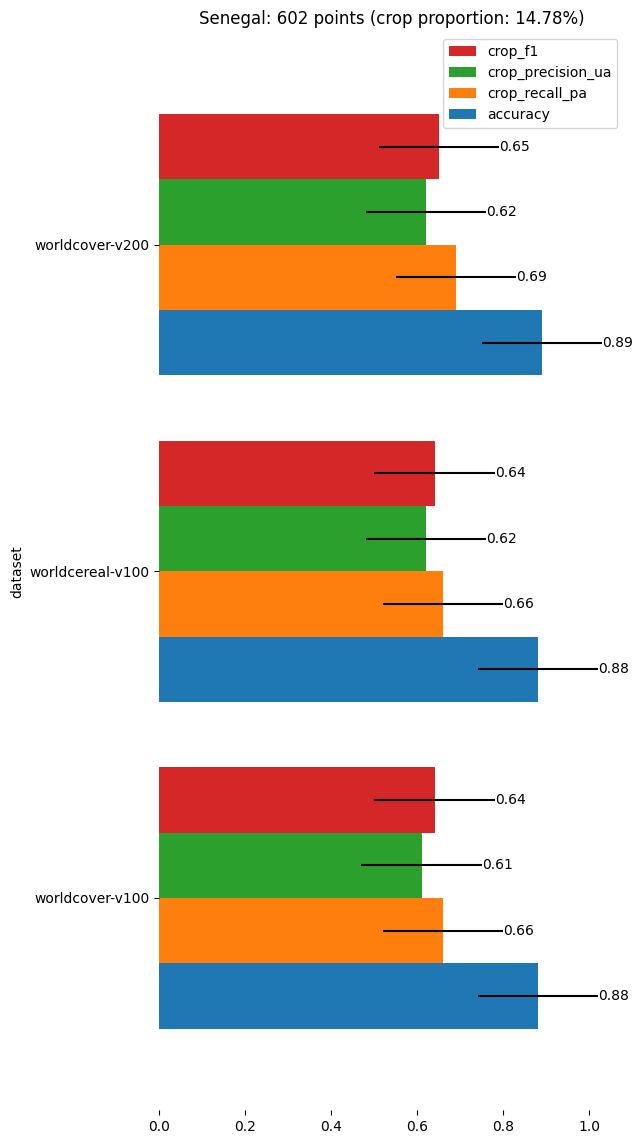

In [90]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"],
    xerr="std_crop_f1",
    kind="barh",
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

In [116]:
fao_stat = pd.read_csv("FAOSTAT_data_en_3-13-2024.csv")
# fao_stat = fao_stat[fao_stat['Area'] == country]
fao_stat = fao_stat[fao_stat['Area'] == country]['Value'].mean() * 1000
# fao_stat = fao_stat[fao_stat['Year Code'] == reference_year]['Value'] * 1000
results = pd.concat([results, pd.DataFrame({'dataset':['FAOSTAT'], 'area_ha':fao_stat, 'err_ha':0}).set_index(['dataset'])])

In [115]:
fao_stat[fao_stat['Area'] == country]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
56,RL,Land Use,686,Senegal,5110,Area,6620,Cropland,2018,2018,1000 ha,3758.0,I,Imputed value,NaN
57,RL,Land Use,686,Senegal,5110,Area,6620,Cropland,2019,2019,1000 ha,3795.0,I,Imputed value,NaN
58,RL,Land Use,686,Senegal,5110,Area,6620,Cropland,2020,2020,1000 ha,3830.0,I,Imputed value,NaN
59,RL,Land Use,686,Senegal,5110,Area,6620,Cropland,2021,2021,1000 ha,3911.0,I,Imputed value,NaN


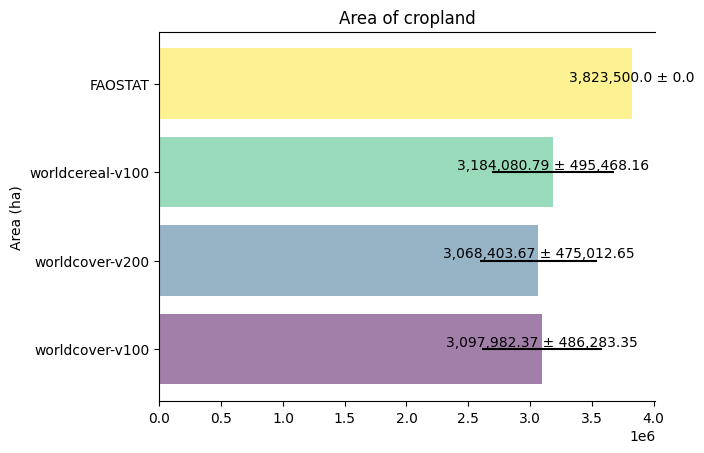

In [110]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

n = len(results)
colors = plt.cm.viridis(np.linspace(0, 1, n))

ax.barh(
    results.index,
    results["area_ha"],
    xerr=results["err_ha"],
    align="center",
    alpha=0.5,
    ecolor="black",
    color= colors
)

for i, (value, err) in enumerate(zip(results["area_ha"], results["err_ha"])):
    ax.text(value, i, f"{value:,} ± {err:,}", ha="center", va="bottom")
ax.set_ylabel("Area (ha)")
ax.set_title("Area of cropland")
ax.spines["right"].set_visible(False)
plt.show()